In [4]:
# scorer
from functools import cache

import nltk
import numpy as np
import spacy
import torch
from nltk import ngrams
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead
import torch.nn.functional as F
from scipy.spatial.distance import cosine, euclidean
from typing import List


class Scorer:
    def __init__(self, lang: str):
        self.device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
        self.spacy_processor = (
            spacy.load("en_core_web_sm") if lang == "en-sent" else spacy.load("de_core_news_md")
        )
        self.tokenizer = (
            AutoTokenizer.from_pretrained("sentence-transformers/all-distilroberta-v1",use_auth_token=None)
            if lang == "en-sent"
            else AutoTokenizer.from_pretrained(
                "sentence-transformers/distiluse-base-multilingual-cased-v1"
            )
        )
        self.model = (
            AutoModel.from_pretrained("sentence-transformers/all-distilroberta-v1", use_auth_token=None)
            .eval()
            .to(self.device)
            if lang == "en-sent"
            else AutoModelWithLMHead.from_pretrained(
                "sentence-transformers/distiluse-base-multilingual-cased-v1"
            )
            .eval()
            .to(self.device)
        )
        self.lang = lang

    @cache
    def _tokenize(self, s: str, max_len: int = None):
        # Cut string at the LM sub-word token length to mimic the generation setting
        if max_len:
            s = self.tokenizer.decode(
                self.tokenizer(
                    s,
                    padding=False,
                    truncation=True,
                    max_length=max_len,
                    add_special_tokens=False,
                ).input_ids
            )

        doc = self.spacy_processor(s.strip())
        return doc

    @staticmethod
    def _mean_pooling(model_output, attention_mask):
        token_embeddings = model_output.hidden_states[-1]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def ngram_overlap(
        self,
        string1: str,
        string2: str,
        max_len1: int,
        max_len2: int,
        n: int,
        pos: bool = False,
    ):
        tokenized_string1 = self._tokenize(string1, max_len=max_len1)
        ngrams1 = list(
            ngrams(
                [token.pos_ if pos else token.text.lower() for token in tokenized_string1],
                n,
            )
        )
        tokenized_string2 = self._tokenize(string2, max_len=max_len2)
        ngrams2 = list(
            ngrams(
                [token.pos_ if pos else token.text.lower() for token in tokenized_string2],
                n,
            )
        )

        count_1_in_2 = sum([1 if ngram2 in ngrams1 else 0 for ngram2 in ngrams2])
        count_2_in_1 = sum([1 if ngram1 in ngrams2 else 0 for ngram1 in ngrams1])
        combined_length = len(ngrams1) + len(ngrams2)
        return (
            (count_1_in_2 + count_2_in_1) / combined_length if combined_length > 0 else float("nan")
        )

    def compute_embeddings(self, strings: List[str], max_len: int):
        tokenized_strings = [self._tokenize(string, max_len=max_len).text for string in strings]
        encoded_input = self.tokenizer(tokenized_strings, padding=True, return_tensors="pt")
        with torch.no_grad():
            model_output = self.model(**encoded_input.to(self.device), output_hidden_states=True)
        batch_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"])
        return F.normalize(batch_embeddings, p=2, dim=1).to("cpu").numpy()

    @staticmethod
    def cosine_similarity(embed1: np.ndarray, embed2: np.ndarray):
        return -cosine(embed1, embed2) + 1

    @staticmethod
    def euclidean_similarity(embed1: np.ndarray, embed2: np.ndarray):
        return 1 / (1 + euclidean(embed1, embed2))

    def length(self, string: str):
        doc = self._tokenize(string)
        return len([token for token in doc])


### Step 1: Quantitative Comparison of Generated and Human NLI Explanations

In [ ]:
import os
import json
from scorer import Scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
from tqdm import tqdm

nltk.download('punkt')
nltk.download('punkt_tab')

# Config
human_jsonl = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/data/esnli/esnli_split_with_highlight.jsonl"
generated_dir = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/Llama3/llama_taxonomy_human"
output_path = "scoring_results_llama_taxonomy_human.jsonl"

# Initialize scorers
scorer = Scorer(lang="en-sent")
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smooth_fn = SmoothingFunction().method1

# Load human explanations
human_data = {}
with open(human_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        pair_id = data["pairID"]
        explanation = data.get("explanation", "").strip()
        if explanation:
            if pair_id not in human_data:
                human_data[pair_id] = []
            human_data[pair_id].append(explanation)

print(f"✅ Loaded human explanations for {len(human_data)} pairIDs.\n")

# Process
scores_summary = []

file_list = [fname for fname in os.listdir(generated_dir) if fname.endswith(".txt")]
for fname in tqdm(file_list, desc="Scoring explanations", ncols=100):
    pair_id = fname.replace(".txt", "")
    file_path = os.path.join(generated_dir, fname)

    with open(file_path, "r", encoding="utf-8") as f:
        gen_expls = [line.strip() for line in f if line.strip()]

    if pair_id not in human_data:
        print(f"⚠️ No human explanations: {pair_id}, skipped.")
        continue

    human_expls = human_data[pair_id]
    per_expl_scores = []

    for gen_expl in gen_expls:
        # Collect scores
        cosine_scores = []
        euclidean_scores = []
        bleu_scores = []
        rougeL_scores = []
        ngram1_scores = []
        ngram2_scores = []
        ngram3_scores = []
        syn_ngram1_scores = []
        syn_ngram2_scores = []
        syn_ngram3_scores = []

        expl_length = scorer.length(gen_expl)

        # Compare to each human reference
        for human_expl in human_expls:
            # Embedding-based
            embeddings = scorer.compute_embeddings([gen_expl, human_expl], max_len=256)
            cosine_sim = scorer.cosine_similarity(embeddings[0], embeddings[1])
            euclidean_sim = scorer.euclidean_similarity(embeddings[0], embeddings[1])

            # BLEU
            reference = nltk.word_tokenize(human_expl)
            candidate = nltk.word_tokenize(gen_expl)
            bleu = sentence_bleu([reference], candidate, smoothing_function=smooth_fn)

            # ROUGE-L
            rougeL = rouge.score(human_expl, gen_expl)['rougeL'].fmeasure

            # Lexical n-gram overlap
            n1 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=1, pos=False)
            n2 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=2, pos=False)
            n3 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=3, pos=False)

            # Syntactic n-gram overlap
            syn1 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=1, pos=True)
            syn2 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=2, pos=True)
            syn3 = scorer.ngram_overlap(gen_expl, human_expl, 256, 256, n=3, pos=True)

            # Append best across references
            cosine_scores.append(cosine_sim)
            euclidean_scores.append(euclidean_sim)
            bleu_scores.append(bleu)
            rougeL_scores.append(rougeL)
            ngram1_scores.append(n1)
            ngram2_scores.append(n2)
            ngram3_scores.append(n3)
            syn_ngram1_scores.append(syn1)
            syn_ngram2_scores.append(syn2)
            syn_ngram3_scores.append(syn3)

        per_expl_scores.append({
            "explanation": gen_expl,
            "length": expl_length,
            "best_cosine": max(cosine_scores),
            "best_euclidean": max(euclidean_scores),
            "best_bleu": max(bleu_scores),
            "best_rougeL": max(rougeL_scores),
            "best_ngram1": max(ngram1_scores),
            "best_ngram2": max(ngram2_scores),
            "best_ngram3": max(ngram3_scores),
            "best_syn_ngram1": max(syn_ngram1_scores),
            "best_syn_ngram2": max(syn_ngram2_scores),
            "best_syn_ngram3": max(syn_ngram3_scores),
        })

    if per_expl_scores:
        avg_scores = {metric: sum(item[metric] for item in per_expl_scores) / len(per_expl_scores)
                      for metric in per_expl_scores[0].keys() if metric != "explanation"}
    else:
        avg_scores = {metric: 0.0 for metric in [
            "length", "best_cosine", "best_euclidean", "best_bleu", "best_rougeL",
            "best_ngram1", "best_ngram2", "best_ngram3",
            "best_syn_ngram1", "best_syn_ngram2", "best_syn_ngram3"
        ]}

    scores_summary.append({
        "pairID": pair_id,
        "average_scores": avg_scores,
        "details": per_expl_scores
    })

    print(f"{pair_id}: {avg_scores}")

# Save results
with open(output_path, "w", encoding="utf-8") as out_f:
    for item in scores_summary:
        out_f.write(json.dumps(item, ensure_ascii=False, default=float) + "\n")

print(f"\nSaved combined scoring results to {output_path}")

# Compute overall averages
overall = {metric: 0.0 for metric in avg_scores.keys()}
for item in scores_summary:
    for metric in avg_scores.keys():
        overall[metric] += item["average_scores"][metric]
count = len(scores_summary)
if count > 0:
    print("\n🎯 Overall Averages:")
    for metric in avg_scores.keys():
        avg = overall[metric] / count
        print(f"{metric}: {avg:.4f}")
else:
    print("No valid pairIDs processed for overall average.")


In [ ]:
# Compute overall averages
overall = {metric: 0.0 for metric in avg_scores.keys()}
for item in scores_summary:
    for metric in avg_scores.keys():
        overall[metric] += item["average_scores"][metric]
count = len(scores_summary)
if count > 0:
    print("\n🎯 Overall Averages:")
    for metric in avg_scores.keys():
        avg = overall[metric] / count
        print(f"{metric}: {avg:.4f}")
else:
    print("⚠️ No valid pairIDs processed for overall average.")

In [7]:
import json

# Load saved scoring results
output_path = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/scoring_results_llama_model_highlight_marked.jsonl"
scores_summary = []
with open(output_path, "r", encoding="utf-8") as f:
    for line in f:
        scores_summary.append(json.loads(line))

# Compute overall averages
if scores_summary:
    all_metrics = scores_summary[0]["average_scores"].keys()
    overall = {metric: 0.0 for metric in all_metrics}
    for item in scores_summary:
        for metric in all_metrics:
            overall[metric] += item["average_scores"][metric]
    count = len(scores_summary)
    print("\n🎯 Overall Averages:")
    for metric in all_metrics:
        avg = overall[metric] / count
        print(f"{metric}: {avg:.4f}")
else:
    print("No data found in saved results.")



🎯 Overall Averages:
length: 29.7632
best_cosine: 0.4001
best_euclidean: 0.4855
best_bleu: 0.0212
best_rougeL: 0.2272
best_ngram1: 0.2996
best_ngram2: 0.0446
best_ngram3: 0.0137
best_syn_ngram1: 0.8315
best_syn_ngram2: 0.3849
best_syn_ngram3: 0.1495


### Step 2: Visualization

In [ ]:
import json
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull,QhullError
from scorer import Scorer
from matplotlib.patches import Polygon
from tqdm import tqdm

# paths
human_jsonl = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/data/esnli/esnli_split_with_highlight.jsonl"
base_dir = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/Llama3/llama_model_highlight_index"
output_dir = "./tsne_visualizations/gpt"
stats_file = "./tsne_convexhull_stats_gpt.csv"

os.makedirs(output_dir, exist_ok=True)

# shape + color per mode
generation_modes = {
    "gpt4o_label": {'marker': 'o', 'color': '#d62728'},
    "gpt4o_highlight_index": {'marker': 's', 'color': '#2ca02c'},
    #"llama_highlight_marked": {'marker': '^', 'color': '#ff7f0e'},
    #"deepseek_taxonomy_filtered": {'marker': 'D', 'color': '#9467bd'}
    "gpt4o_taxonomy_filtered": {'marker': 'p', 'color': '#17becf'},
}

# load all pairIDs
pair_ids = set()
with open(human_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        pair_ids.add(data["pairID"])

print(f"Found {len(pair_ids)} unique pairIDs.")

# initialize scorer
scorer = Scorer(lang="en-sent")

# record results
results = []

for pair_id in tqdm(pair_ids, desc="Processing pairIDs"):
    # load human explanations
    human_expls = []
    with open(human_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            if data["pairID"] == pair_id:
                explanation = data.get("explanation", "").strip()
                if explanation:
                    human_expls.append(explanation)

    if not human_expls:
        continue

    # load model explanations
    model_expls_all = {}
    for mode in generation_modes.keys():
        mode_dir = os.path.join(base_dir, mode)
        gen_file = os.path.join(mode_dir, f"{pair_id}.txt")
        if not os.path.exists(gen_file):
            model_expls_all[mode] = []
            continue
        with open(gen_file, "r", encoding="utf-8") as f:
            expls = [line.strip() for line in f if line.strip()]
        model_expls_all[mode] = expls

    # prepare embeddings
    all_expls = human_expls.copy()
    for expls in model_expls_all.values():
        all_expls.extend(expls)

    if len(all_expls) < 3:
        continue

    embeddings = scorer.compute_embeddings(all_expls, max_len=256)

    # TSNE projection
    os.environ["OMP_NUM_THREADS"] = "1"
    num_points = len(embeddings)
    perplexity = min(5, num_points - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    emb_2d = tsne.fit_transform(embeddings)

    # separate points
    human_2d = emb_2d[:len(human_expls)]
    mode_points_2d = {}
    start_idx = len(human_expls)
    for mode, expls in model_expls_all.items():
        end_idx = start_idx + len(expls)
        mode_points_2d[mode] = emb_2d[start_idx:end_idx]
        start_idx = end_idx

    # plot setup
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # plot human points
    plt.scatter(human_2d[:, 0], human_2d[:, 1], c='blue', marker='*', s=60, label='Human')

    # plot model points
    for mode, points in mode_points_2d.items():
        if len(points) > 0:
            plt.scatter(points[:, 0], points[:, 1],
                        marker=generation_modes[mode]['marker'],
                        s=50,
                        c=generation_modes[mode]['color'],
                        label=mode)

    # function to check if all human points inside hull
    def points_inside_hull(points, hull_points):
        hull = ConvexHull(hull_points)
        from matplotlib.path import Path
        path = Path(hull_points[hull.vertices])
        return all(path.contains_point(p) for p in points)

    # store per-mode coverage stats
    mode_coverage = {}

    # draw convex hulls
    for name, points in [('Human', human_2d)] + list(mode_points_2d.items()):
        if len(points) >= 3:
            if np.linalg.matrix_rank(points - points[0]) < 2:
                print(f"⚠ Skipping {name}: points are collinear or degenerate")
                mode_coverage[name] = 'No'
                continue
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            polygon_color = 'blue' if name == 'Human' else 'gray'

            poly = Polygon(hull_points, facecolor=polygon_color, edgecolor='none', alpha=0.15)
            ax.add_patch(poly)

            if name != 'Human':
                covered = points_inside_hull(human_2d, hull_points)
                mode_coverage[name] = 'Yes' if covered else 'No'
        else:
            mode_coverage[name] = 'No'

    results.append({
        "pair_id": pair_id,
        **{f"{mode}_covers_human": mode_coverage.get(mode, 'No') for mode in generation_modes.keys()}
    })

    # legend + save
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5),
               fontsize=10, frameon=True, fancybox=True, shadow=True)
    plt.title(f"t-SNE of {pair_id}", fontsize=14)
    plt.tight_layout()

    safe_pair_id = pair_id.replace("/", "_").replace("\\", "_")
    save_path = os.path.join(output_dir, f"{safe_pair_id}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

# save CSV results
fieldnames = ["pair_id"] + [f"{mode}_covers_human" for mode in generation_modes.keys()]
with open(stats_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"\n✅ All stats saved to {stats_file}")

In [48]:
import json
import os
import csv
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull, QhullError
from shapely.geometry import Polygon, Point
from tqdm import tqdm
from scorer import Scorer

# paths
human_jsonl = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/data/esnli/esnli_split_with_highlight.jsonl"
base_dir = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/Llama3"
output_csv = "./tsne_convexhull_stats_llama_extended.csv"

generation_modes = {
    "llama_label": {},
    "llama_highlight_index": {},
    "llama_taxonomy_filtered": {},
}

# load all pairIDs
pair_ids = set()
with open(human_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        pair_ids.add(data["pairID"])

print(f"Found {len(pair_ids)} unique pairIDs.")

# initialize scorer
scorer = Scorer(lang="en-sent")

# record results
results = []

for pair_id in tqdm(pair_ids, desc="Processing pairIDs"):
    # load human explanations
    human_expls = []
    with open(human_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            if data["pairID"] == pair_id:
                explanation = data.get("explanation", "").strip()
                if explanation:
                    human_expls.append(explanation)

    if not human_expls:
        continue

    # load model explanations
    model_expls_all = {}
    for mode in generation_modes.keys():
        mode_dir = os.path.join(base_dir, mode)
        gen_file = os.path.join(mode_dir, f"{pair_id}.txt")
        if not os.path.exists(gen_file):
            model_expls_all[mode] = []
            continue
        with open(gen_file, "r", encoding="utf-8") as f:
            expls = [line.strip() for line in f if line.strip()]
        model_expls_all[mode] = expls

    # prepare embeddings
    all_expls = human_expls.copy()
    for expls in model_expls_all.values():
        all_expls.extend(expls)

    if len(all_expls) < 3:
        continue

    embeddings = scorer.compute_embeddings(all_expls, max_len=256)

    # TSNE projection
    os.environ["OMP_NUM_THREADS"] = "1"
    num_points = len(embeddings)
    perplexity = min(5, num_points - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    emb_2d = tsne.fit_transform(embeddings)

    # separate points
    human_2d = emb_2d[:len(human_expls)]
    mode_points_2d = {}
    start_idx = len(human_expls)
    for mode, expls in model_expls_all.items():
        end_idx = start_idx + len(expls)
        mode_points_2d[mode] = emb_2d[start_idx:end_idx]
        start_idx = end_idx

    # human convex hull
    if len(human_2d) >= 3:
        try:
            human_hull = ConvexHull(human_2d)
            human_poly = Polygon(human_2d[human_hull.vertices])
            human_area = human_poly.area
        except QhullError:
            human_poly = None
            human_area = 0.0
    else:
        human_poly = None
        human_area = 0.0

    # initialize row and record human area
    row = {"pair_id": pair_id, "human_hull_area": human_area}

    for mode, points in mode_points_2d.items():
        row[f"{mode}_full_covers_human"] = 'No'
        row[f"{mode}_partial_covers_human"] = 'No'
        row[f"{mode}_hull_area"] = 0.0
        row[f"{mode}_hull_area_ratio"] = 0.0  # mode area / human area
        row[f"{mode}_overlap_ratio"] = 0.0

        if len(points) >= 3:
            try:
                mode_hull = ConvexHull(points)
                mode_poly = Polygon(points[mode_hull.vertices])

                # full coverage check
                all_covered = all(mode_poly.covers(Point(p)) for p in human_2d)
                row[f"{mode}_full_covers_human"] = 'Yes' if all_covered else 'No'

                # partial coverage check (any point)
                any_covered = any(mode_poly.covers(Point(p)) for p in human_2d)
                row[f"{mode}_partial_covers_human"] = 'Yes' if any_covered else 'No'

                # mode hull area
                mode_area = mode_poly.area
                row[f"{mode}_hull_area"] = mode_area

                # area ratio: mode / human
                row[f"{mode}_hull_area_ratio"] = mode_area / human_area if human_area > 0 else 0.0

                # overlap with human hull
                if human_poly and mode_poly.is_valid and human_poly.is_valid:
                    intersection_area = mode_poly.intersection(human_poly).area
                    overlap_ratio = intersection_area / human_area if human_area > 0 else 0.0
                    row[f"{mode}_overlap_ratio"] = overlap_ratio

            except QhullError:
                continue

    results.append(row)

# save CSV
fieldnames = ["pair_id", "human_hull_area"]
for mode in generation_modes.keys():
    fieldnames += [
        f"{mode}_full_covers_human",
        f"{mode}_partial_covers_human",
        f"{mode}_hull_area",
        f"{mode}_hull_area_ratio",  # added
        f"{mode}_overlap_ratio"
    ]

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"\n✅ All extended stats saved to {output_csv}")


Found 1002 unique pairIDs.


Processing pairIDs: 100%|██████████| 1002/1002 [09:43<00:00,  1.72it/s]


✅ All extended stats saved to ./tsne_convexhull_stats_llama_extended.csv


In [ ]:
import csv

input_csv = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/tsne_convexhull_stats_llama_extended.csv"

# 初始化统计
stats = {}
modes = set()

with open(input_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    rows = list(reader)

for field in rows[0].keys():
    if field.endswith("_full_covers_human"):
        mode = field.replace("_full_covers_human", "")
        modes.add(mode)

for mode in modes:
    stats[mode] = {
        "count": 0,
        "full_yes": 0,
        "partial_yes": 0,
        "total_area": 0.0,
        "total_overlap": 0.0,
        "total_area_ratio": 0.0,# 新增：模型面积 / human面积 累积
        "total_recall" = 0.0,
        "total_precision" = 0.0
    }

# 遍历每一行统计
for row in rows:
    human_area = float(row.get("Human_hull_area", 0))
    for mode in modes:
        stats[mode]["count"] += 1
        if row[f"{mode}_full_covers_human"] == "Yes":
            stats[mode]["full_yes"] += 1
        if row[f"{mode}_partial_covers_human"] == "Yes":
            stats[mode]["partial_yes"] += 1
        mode_area = float(row[f"{mode}_hull_area"])
        stats[mode]["total_area"] += mode_area
        stats[mode]["total_overlap"] += float(row[f"{mode}_overlap_ratio"])
        area_ratio = float(row[f"{mode}_hull_area_ratio"])
        stats[mode]["total_area_ratio"] += area_ratio
        

# 打印汇总结果
print("\n=== Summary Statistics ===\n")
for mode in sorted(modes):
    count = stats[mode]["count"]
    full_cover_ratio = stats[mode]["full_yes"] / count * 100 if count else 0
    partial_cover_ratio = stats[mode]["partial_yes"] / count * 100 if count else 0
    avg_area = stats[mode]["total_area"] / count if count else 0
    avg_overlap = stats[mode]["total_overlap"] / count if count else 0
    avg_area_ratio = stats[mode]["total_area_ratio"] / count if count else 0

    print(f"Mode: {mode}")
    print(f"  Total Count:             {count}")
    print(f"  Full Cover (Yes %):      {full_cover_ratio:.2f}% ({stats[mode]['full_yes']} Yes)")
    print(f"  Partial Cover (Yes %):   {partial_cover_ratio:.2f}% ({stats[mode]['partial_yes']} Yes)")
    print(f"  Avg Hull Area:           {avg_area:.4f}")
    print(f"  Avg Overlap Ratio:       {avg_overlap:.4f}")
    print(f"  Avg Area / Human Area:   {avg_area_ratio:.4f}")
    print()



=== Summary Statistics ===

Mode: llama_highlight_index
  Total Count:             1002
  Full Cover (Yes %):      0.50% (5 Yes)
  Partial Cover (Yes %):   8.18% (82 Yes)
  Avg Hull Area:           6805.1416
  Avg Overlap Ratio:       0.0645
  Avg Area / Human Area:   41.3254

Mode: llama_label
  Total Count:             1002
  Full Cover (Yes %):      1.70% (17 Yes)
  Partial Cover (Yes %):   15.37% (154 Yes)
  Avg Hull Area:           12147.9062
  Avg Overlap Ratio:       0.1217
  Avg Area / Human Area:   89.6387

Mode: llama_taxonomy_filtered
  Total Count:             1002
  Full Cover (Yes %):      16.67% (167 Yes)
  Partial Cover (Yes %):   65.17% (653 Yes)
  Avg Hull Area:           26401.4832
  Avg Overlap Ratio:       0.5983
  Avg Area / Human Area:   293.9580



In [14]:
import csv

input_csv = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/tsne_convexhull_stats_deepseek_extended.csv"

# 初始化统计
stats = {}
modes = set()
skipped = 0  # 记录跳过样本数量

with open(input_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    rows = list(reader)

# 找出所有生成模式
for field in rows[0].keys():
    if field.endswith("_full_covers_human"):
        mode = field.replace("_full_covers_human", "")
        modes.add(mode)

# 初始化每种模式的统计值
for mode in modes:
    stats[mode] = {
        "count": 0,
        "full_yes": 0,
        "partial_yes": 0,
        "total_area": 0.0,
        "total_overlap": 0.0,
        "total_area_ratio": 0.0,
        "total_recall": 0.0,     # I / H
        "total_precision": 0.0,  # I / M
    }

# 遍历数据进行统计
for row in rows:
    try:
        human_area = float(row.get("human_hull_area", 0))
    except ValueError:
        human_area = 0.0

    if human_area == 0.0:
        skipped += 1
        continue  # 💡 跳过无效样本

    for mode in modes:
        stats[mode]["count"] += 1

        if row.get(f"{mode}_full_covers_human", "No") == "Yes":
            stats[mode]["full_yes"] += 1
        if row.get(f"{mode}_partial_covers_human", "No") == "Yes":
            stats[mode]["partial_yes"] += 1

        try:
            model_area = float(row.get(f"{mode}_hull_area", 0))
            area_ratio = float(row.get(f"{mode}_hull_area_ratio", 0))
            overlap_ratio = float(row.get(f"{mode}_overlap_ratio", 0))  # = I / H
        except ValueError:
            model_area, area_ratio, overlap_ratio = 0.0, 0.0, 0.0

        stats[mode]["total_area"] += model_area
        stats[mode]["total_overlap"] += overlap_ratio
        stats[mode]["total_area_ratio"] += area_ratio

        recall = overlap_ratio  # 已定义为 I / H
        intersection_area = overlap_ratio * human_area
        precision = intersection_area / model_area if model_area > 0 else 0.0

        stats[mode]["total_recall"] += recall
        stats[mode]["total_precision"] += precision

# 打印汇总结果
print("\n=== Summary Statistics ===\n")
for mode in sorted(modes):
    count = stats[mode]["count"]
    if count == 0:
        continue
    full_cover_ratio = stats[mode]["full_yes"] / count * 100
    partial_cover_ratio = stats[mode]["partial_yes"] / count * 100
    avg_area = stats[mode]["total_area"] / count
    avg_overlap = stats[mode]["total_overlap"] / count
    avg_area_ratio = stats[mode]["total_area_ratio"] / count
    avg_recall = stats[mode]["total_recall"] / count
    avg_precision = stats[mode]["total_precision"] / count

    print(f"Mode: {mode}")
    print(f"  Total Count:             {count}")
    print(f"  Full Cover (Yes %):      {full_cover_ratio:.2f}% ({stats[mode]['full_yes']} Yes)")
    print(f"  Partial Cover (Yes %):   {partial_cover_ratio:.2f}% ({stats[mode]['partial_yes']} Yes)")
    print(f"  Avg Hull Area:           {avg_area:.4f}")
    print(f"  Avg Overlap (I / H):     {avg_overlap:.4f} (Recall)")
    print(f"  Avg Area / Human Area:   {avg_area_ratio:.4f}")
    print(f"  Avg Precision (I / M):   {avg_precision:.6f}")
    print()

# 打印被跳过样本数
print(f"⚠️ Skipped {skipped} samples with zero human hull area.")



=== Summary Statistics ===

Mode: deepseek_highlight_index
  Total Count:             997
  Full Cover (Yes %):      2.21% (22 Yes)
  Partial Cover (Yes %):   14.84% (148 Yes)
  Avg Hull Area:           7080.4099
  Avg Overlap (I / H):     0.1260 (Recall)
  Avg Area / Human Area:   1424.6413
  Avg Precision (I / M):   0.029270

Mode: deepseek_label
  Total Count:             997
  Full Cover (Yes %):      4.01% (40 Yes)
  Partial Cover (Yes %):   20.46% (204 Yes)
  Avg Hull Area:           11637.4953
  Avg Overlap (I / H):     0.1755 (Recall)
  Avg Area / Human Area:   987.3604
  Avg Precision (I / M):   0.026777

Mode: deepseek_taxonomy_filtered
  Total Count:             997
  Full Cover (Yes %):      17.75% (177 Yes)
  Partial Cover (Yes %):   61.89% (617 Yes)
  Avg Hull Area:           23359.3570
  Avg Overlap (I / H):     0.5494 (Recall)
  Avg Area / Human Area:   1181.9060
  Avg Precision (I / M):   0.037862

⚠️ Skipped 5 samples with zero human hull area.


### Redundancy Detection

In [58]:
import os
import json
import nltk
from tqdm import tqdm
from scorer import Scorer

def batch_redundancy_detection(
    human_jsonl,
    generated_dir,
    output_path,
    similarity_threshold=0.5,
    euclidean_threshold=0.5,
    ngram2_threshold=0.15,
    ngram3_threshold=0.08
):
    
    scorer = Scorer(lang="en-sent")

    # load human explanations
    human_data = {}
    with open(human_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            pair_id = data["pairID"]
            explanation = data.get("explanation", "").strip()
            if explanation:
                if pair_id not in human_data:
                    human_data[pair_id] = []
                human_data[pair_id].append(explanation)

    print(f"Loaded human explanations for {len(human_data)} pairIDs.")

    scores_summary = []
    
    file_list = [fname for fname in os.listdir(generated_dir) if fname.endswith(".txt")]

    for fname in tqdm(file_list, desc="Processing pairIDs"):
        pair_id = fname.replace(".txt", "")
        file_path = os.path.join(generated_dir, fname)

        with open(file_path, "r", encoding="utf-8") as f:
            gen_expls = [line.strip() for line in f if line.strip()]

        if pair_id not in human_data:
            print(f"!No human explanations: {pair_id}")
            continue

        human_expls = human_data[pair_id]
        human_lengths = [scorer.length(e) for e in human_expls]
        avg_human_len = max(1, int(sum(human_lengths) / len(human_lengths)))

        per_expl_scores = []

        for idx, gen_expl in enumerate(gen_expls, 1):
            tokens = nltk.word_tokenize(gen_expl)
            total_tokens = len(tokens)

            windows = []
            if total_tokens < avg_human_len:
                windows = [" ".join(tokens)]
                tqdm.write(f"{pair_id} (expl {idx}): Explanation too short ({total_tokens} tokens); using full text as one window.")
            else:
                for i in range(0, total_tokens - avg_human_len + 1):
                    window = tokens[i:i + avg_human_len]
                    window_text = " ".join(window)
                    windows.append(window_text)

            redundant_count = 0

            for window_text in windows:
                sim_scores = []
                eucl_scores = []
                ngram2_scores = []
                ngram3_scores = []

                for human_expl in human_expls:
                    embeddings = scorer.compute_embeddings([window_text, human_expl], max_len=256)
                    cosine_sim = scorer.cosine_similarity(embeddings[0], embeddings[1])
                    eucl_sim = scorer.euclidean_similarity(embeddings[0], embeddings[1])
                    ngram2 = scorer.ngram_overlap(window_text, human_expl, 256, 256, n=2, pos=False)
                    ngram3 = scorer.ngram_overlap(window_text, human_expl, 256, 256, n=3, pos=False)

                    sim_scores.append(cosine_sim)
                    eucl_scores.append(eucl_sim)
                    ngram2_scores.append(ngram2)
                    ngram3_scores.append(ngram3)

                max_cosine = max(sim_scores)
                max_euclidean = max(eucl_scores)
                max_ngram2 = max(ngram2_scores)
                max_ngram3 = max(ngram3_scores)

                criteria = [
                    max_cosine < similarity_threshold,
                    max_euclidean < euclidean_threshold,
                    max_ngram2 < ngram2_threshold,
                    max_ngram3 < ngram3_threshold
                ]

                is_redundant = sum(criteria) >= 2
                
                if is_redundant:
                    redundant_count += 1

            total_windows = len(windows)
            redundancy_rate = redundant_count / total_windows if total_windows > 0 else 0.0

            per_expl_scores.append({
                "explanation": gen_expl,
                "redundant_windows": redundant_count,
                "total_windows": total_windows,
                "redundancy_rate": float(redundancy_rate)
            })

            tqdm.write(f"{pair_id} (expl {idx}): {redundant_count}/{total_windows} redundant windows ({redundancy_rate:.2%})")

        # calculate redundancy rate
        if per_expl_scores:
            avg_redundancy = sum(item["redundancy_rate"] for item in per_expl_scores) / len(per_expl_scores)
        else:
            avg_redundancy = 0.0

        scores_summary.append({
            "pairID": pair_id,
            "average_redundancy_rate": float(avg_redundancy),
            "details": per_expl_scores
        })

        print(f"{pair_id}: Avg redundancy rate = {avg_redundancy:.2%}")

    # save results
    with open(output_path, "w", encoding="utf-8") as out_f:
        for item in scores_summary:
            out_f.write(json.dumps(item, ensure_ascii=False, default=float) + "\n")

    print(f"\nResults saved to {output_path}")

    # calculate overall average redundancy rate
    if scores_summary:
        overall_avg_redundancy = sum(item["average_redundancy_rate"] for item in scores_summary) / len(scores_summary)
        print("\nOverall Average Redundancy Rate:")
        print(f"{overall_avg_redundancy:.2%}")



In [ ]:
batch_redundancy_detection(
    human_jsonl="/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/data/esnli/esnli_split_with_highlight.jsonl",
    generated_dir="/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/Deepseek/deepseek_model_highlight_index",
    output_path="redundancy_results_model_highlight_index.jsonl"
)

In [ ]:
import json

input_path = "/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/evaluation/redundancy_results_deepseek_model_highlight_index.jsonl"
scores_summary = []


with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        if "average_redundancy_rate" in item:
            scores_summary.append(item)

if scores_summary:
    overall_avg_redundancy = sum(item["average_redundancy_rate"] for item in scores_summary) / len(scores_summary)
    print("\n✅ Overall Average Redundancy Rate:")
    print(f"{overall_avg_redundancy:.2%}")
else:
    print("⚠️ No valid entries with 'average_redundancy_rate' found.")



✅ Overall Average Redundancy Rate:
85.07%


In [1]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd

# Step 1: 定义类别及其样本数
label_counts = {
    "Inferential WK": 972,
    "Logic Conflict": 669,
    "Factual WK": 370,
    "Syntactic": 347,
    "Pragmatic": 282,
    "Semantic": 268,
    "Coref. Resolution": 106,
    "Absence of Mention": 94
}

total = sum(label_counts.values())
labels = list(label_counts.keys())

# Step 2: 构建真实标签
true_labels = []
for label, count in label_counts.items():
    true_labels.extend([label] * count)

# Step 3: 构建 Baseline 预测
# Random baseline: 从8类中均匀随机抽取
np.random.seed(42)  # 保持可复现
random_pred = np.random.choice(labels, size=total)

# Majority baseline: 全部预测为出现频率最高的类
majority_class = max(label_counts, key=label_counts.get)
majority_pred = [majority_class] * total

# Step 4: 定义 macro-metric 计算函数
def compute_macro_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return precision * 100, recall * 100, f1 * 100

# Step 5: 计算指标
random_prec, random_rec, random_f1 = compute_macro_metrics(true_labels, random_pred)
majority_prec, majority_rec, majority_f1 = compute_macro_metrics(true_labels, majority_pred)

# Step 6: 计算 accuracy
random_acc = 1 / len(label_counts) * 100  # uniform random
majority_acc = max(label_counts.values()) / total * 100

# Step 7: 生成结果表格
results = {
    "Classifiers": ["Random Baseline", "Majority Baseline"],
    "Accuracy (%)": [random_acc, majority_acc],
    "Precision (%)": [random_prec, majority_prec],
    "Recall (%)": [random_rec, majority_rec],
    "F1 (%)": [random_f1, majority_f1]
}

df = pd.DataFrame(results)
print(df.to_string(index=False))


      Classifiers  Accuracy (%)  Precision (%)  Recall (%)    F1 (%)
  Random Baseline     12.500000      11.792487   10.834734 10.157985
Majority Baseline     31.274131       3.909266   12.500000  5.955882


In [1]:
pip install pillow matplotlib


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# 图片路径（替换为你实际的图片文件名）
image_paths = ['/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/tsne_visualizations/gpt_full_overlap.png', '/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/tsne_visualizations/gpt_partial_overlap.png', '/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/tsne_visualizations/gpt_no_overlap.png']
titles = ['Full Overlap', 'Partial Overlap', 'No Overlap']

# 载入图片
images = [Image.open(p) for p in image_paths]

# 获取统一尺寸
widths, heights = zip(*(img.size for img in images))
max_height = max(heights)
total_width = sum(widths)

# 创建新图像画布（增加顶部空间放标题）
padding_top = 50  # 顶部标题的高度
new_img = Image.new('RGB', (total_width, max_height + padding_top), 'white')

# 加载字体（可选：使用 matplotlib 默认字体）
font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial Bold.ttf", size=30)

# 粘贴图片 + 加标题
draw = ImageDraw.Draw(new_img)
x_offset = 0
for i, img in enumerate(images):
    new_img.paste(img, (x_offset, padding_top))
    # 在图片上方居中画标题
    bbox = draw.textbbox((0, 0), titles[i], font=font)
    text_width = bbox[2] - bbox[0]
    # 设置标题 x 坐标，右边图手动左移一些
    title_x = x_offset + (img.width - text_width) // 2
    if i == 2:  # 最右边一张图
        title_x -= 90  # 向左移动 30 像素（可根据需要调整）

    draw.text((title_x, 10), titles[i], fill='black', font=font)

    x_offset += img.width

# 保存或显示
output_path = 'combined_figure.png'
new_img.save(output_path, "png", resolution=600.0)
print(f"Saved to {output_path}")
new_img.show()


Saved to combined_figure.png


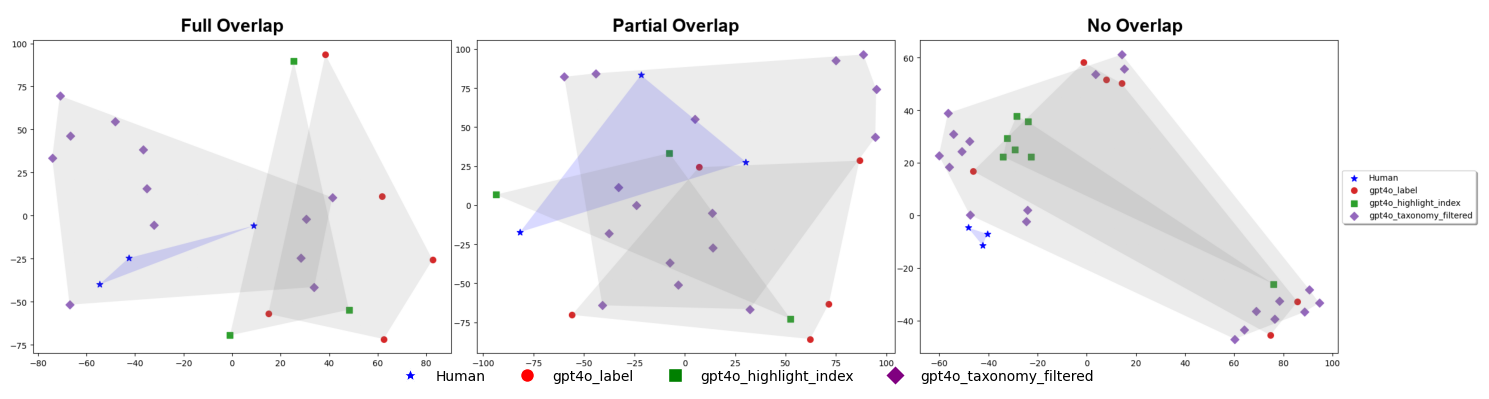

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图像
img = mpimg.imread('/Users/hongpingjun/Desktop/Studium/CL/Masterarbeit/generation/combined_figure.png')

# 创建图像
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(img)
ax.axis('off')

# 创建新的图例（手动重建原来的图例）
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='*', color='w', label='Human', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='gpt4o_label', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='gpt4o_highlight_index', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='D', color='w', label='gpt4o_taxonomy_filtered', markerfacecolor='purple', markersize=10),
]

# 将图例移到底部并横向排列
fig.legend(handles=legend_elements, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.088))


output_pdf = 'combined_with_legend.png'
plt.savefig(output_pdf, format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()
